**MOUNTING DRIVE AND LOADING DATASET**

In [1]:
from google.colab import drive
import pandas as pd
# Mounts Google Drive
drive.mount('/content/drive')
df = pd.read_pickle("/content/drive/MyDrive/ProgettoDataMining/complete_df.pkl")

Mounted at /content/drive


**LIBRARIES**

In [2]:
!pip install tensorflow_addons
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Add, Dropout, Resizing, Rescaling, InputLayer, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.preprocessing.image import load_img
from functools import partial
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**VARIABLES AND PREPROCESSING**

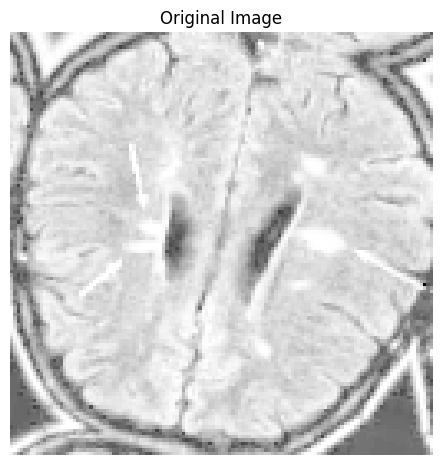

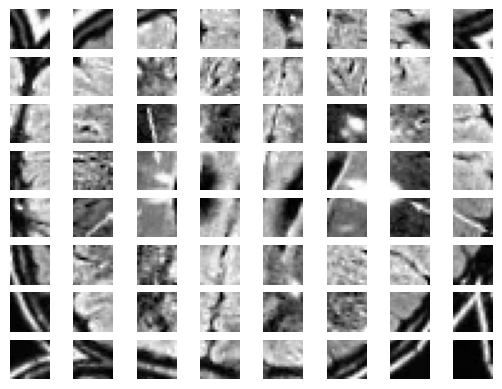

In [3]:
# Constants
learning_rate = 0.0001
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
weight_decay = 0.0001
num_classes = 4
batch_size = 16  # Reduce batch size to manage memory
num_epochs = 50
image_size = 128  # Reduce image size to manage memory
patch_size = 16  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]  # Size of the transformer layers
num_layers = 15
Hidden_size = 64
mlp_head_units = 1024

# Function to preprocess images
def preprocess_images(df, image_size):
    images = df['Image'].values
    resized_images = [cv2.resize(np.array(img), (image_size, image_size)) for img in images]
    images_array = np.stack(resized_images, axis=0)
    images_array = images_array.astype('float32') / 255.0
    images_array = np.expand_dims(images_array, axis=-1)  # Add channel dimension for grayscale images
    return images_array

# Preprocess the images
images = preprocess_images(df, image_size)

# Encode labels
labels = pd.get_dummies(df['Label']).values

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert arrays to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(buffer_size=1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
    RandomFlip("horizontal_and_vertical", seed=42),  # Specify a seed for reproducibility
])

# Define a custom preprocessing function
def process_data(image, label):
    augmented_image = augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset
    .shuffle(1000)
    .map(partial(process_data), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
vali_dataset = (
    val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

input_tensor = next(iter(training_dataset))[0]
patche = tf.image.extract_patches(images=input_tensor,
                                  sizes=[1, patch_size, patch_size, 1],
                                  strides=[1, patch_size, patch_size, 1],
                                  rates=[1, 1, 1, 1],
                                  padding='VALID')

from skimage import exposure
def normalize_image(image):
    min_val, max_val = np.min(image), np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

pic = input_tensor[0].numpy()
pic = exposure.equalize_adapthist(normalize_image(pic), clip_limit=0.01)
pic = exposure.adjust_gamma(pic, 0.3)
plt.figure(figsize=(12, 12))

batch_size, patch_rows, patch_cols, channels = patche.shape
plt.subplot(1, 2, 1)
plt.imshow(pic, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

for i in range(patch_rows):
    for j in range(patch_cols):
        ax = plt.subplot(patch_rows, patch_cols, i * patch_cols + j + 1)
        plt.imshow(patche[0, i, j, :].numpy().reshape(patch_size, patch_size, 1), cmap='gray')
        plt.axis("off")

plt.show()

**MODEL TRAINING**

In [4]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, Hidden_size):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection = Dense(Hidden_size)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=Hidden_size
        )
        self.num_patches = num_patches

    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        patches = tf.image.extract_patches(images=image,
                                           sizes=[1, patch_size, patch_size, 1],
                                           strides=[1, patch_size, patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID'
                                           )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        embedding_input = tf.range(start=0, limit=self.num_patches, delta=1)
        output = self.linear_projection(patches) + self.position_embedding(embedding_input)
        return output

class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads, Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()

        self.multi_head_att = MultiHeadAttention(Num_heads, Hidden_size)

        self.dense_1 = Dense(Hidden_size, activation=tf.nn.gelu)
        self.dense_2 = Dense(Hidden_size, activation=tf.nn.gelu)

    def call(self, input):
        x = self.layer_norm_1(input)
        x1 = self.multi_head_att(x, x)

        x1 = Add()([x1, input])
        x2 = self.layer_norm_2(x1)
        x2 = self.dense_1(x2)
        output = self.dense_1(x2)
        output = Add()([output, x1])

        return output

class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)
loss_function = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
)
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=loss_function,
    metrics=metrics
)

checkpoint_filepath = "/content/drive/MyDrive/ProgettoDataMining/best"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

# Train the model
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]
)


Epoch 1/50
200/200 [==============================] - 87s 117ms/step - loss: 0.9506 - accuracy: 0.6409 - top_k_accuracy: 0.8378 - val_loss: 0.7210 - val_accuracy: 0.7080 - val_top_k_accuracy: 0.8672
Epoch 2/50
200/200 [==============================] - 20s 99ms/step - loss: 0.6685 - accuracy: 0.7320 - top_k_accuracy: 0.9086 - val_loss: 0.6745 - val_accuracy: 0.7168 - val_top_k_accuracy: 0.9080
Epoch 3/50
200/200 [==============================] - 21s 105ms/step - loss: 0.5697 - accuracy: 0.7680 - top_k_accuracy: 0.9308 - val_loss: 0.4965 - val_accuracy: 0.7898 - val_top_k_accuracy: 0.9416
Epoch 4/50
200/200 [==============================] - 18s 90ms/step - loss: 0.4773 - accuracy: 0.8109 - top_k_accuracy: 0.9524 - val_loss: 0.5906 - val_accuracy: 0.7693 - val_top_k_accuracy: 0.9387
Epoch 5/50
200/200 [==============================] - 19s 96ms/step - loss: 0.4660 - accuracy: 0.8053 - top_k_accuracy: 0.9559 - val_loss: 0.4677 - val_accuracy: 0.7796 - val_top_k_accuracy: 0.9620
Epoch 6/

**Loss curves**

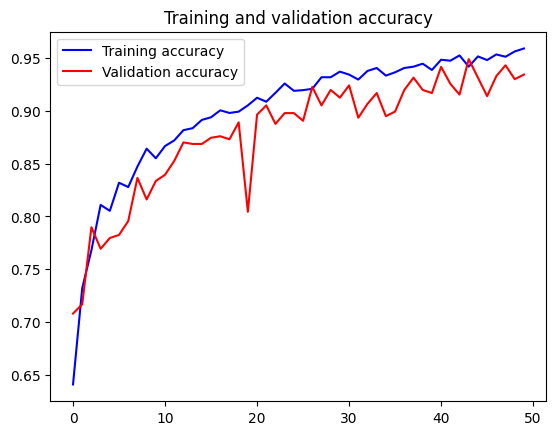

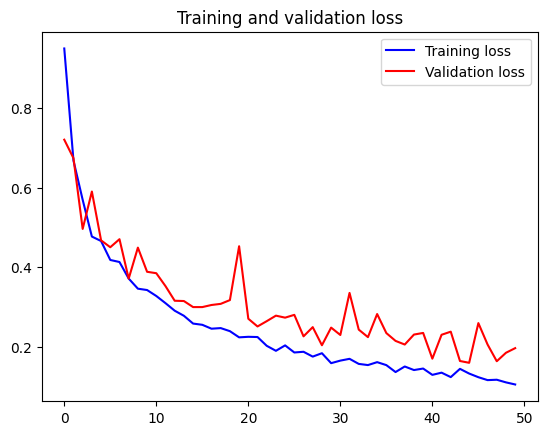

In [5]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

**SAVINGS**

In [6]:
vit.save('/content/drive/MyDrive/ProgettoDataMining/vit2')
vit.save_weights('/content/drive/MyDrive/ProgettoDataMining/vit_weights2')

**PREDICTIONS**

43/43 [==============================] - 2s 38ms/step - loss: 0.2085 - accuracy: 0.9153 - top_k_accuracy: 0.9927


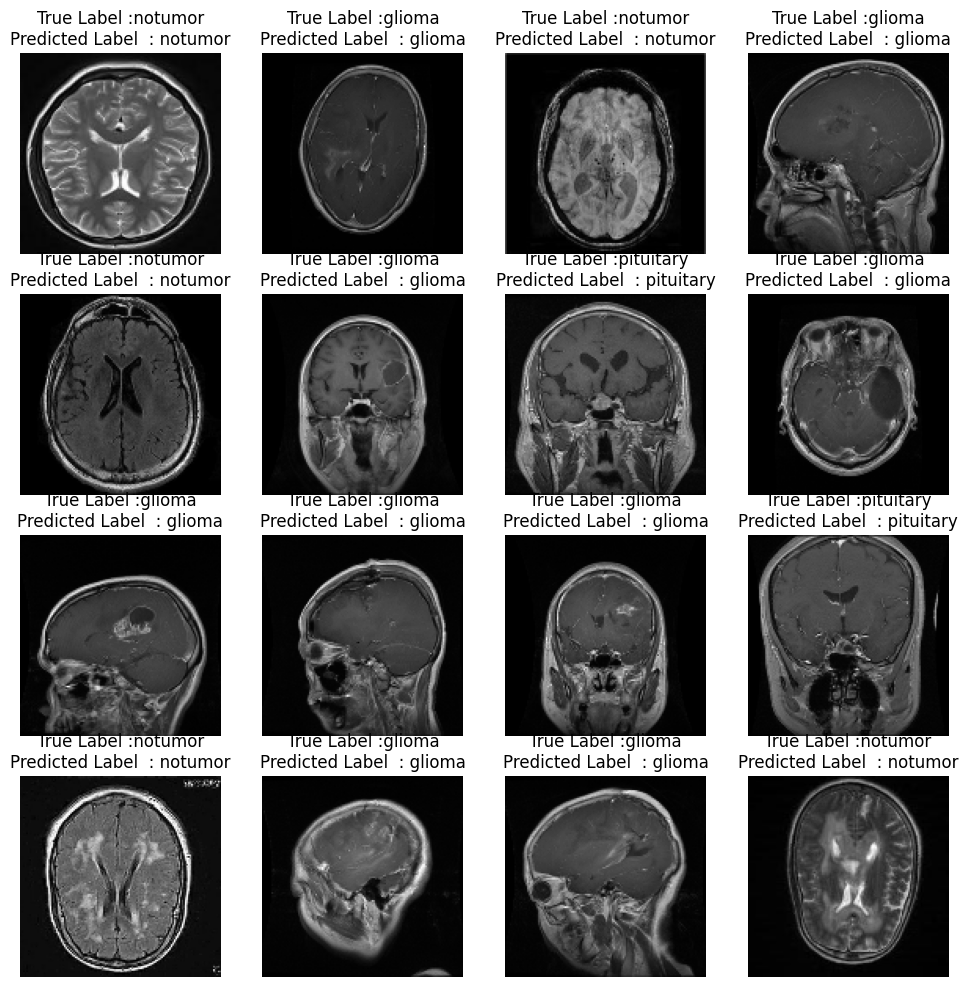

In [7]:
pred = vit.predict(test_dataset)
vit.evaluate(test_dataset)
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255., cmap='gray')
   plt.title("True Label :"+ class_names[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_names[tf.argmax(vit(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

**CONFUSION MATRIX**

In [8]:
loaded_vit = tf.keras.models.load_model('/content/drive/MyDrive/ProgettoDataMining/vit1')

43/43 [==============================] - 5s 50ms/step - loss: 0.1801 - accuracy: 0.9372 - top_k_accuracy: 0.9942


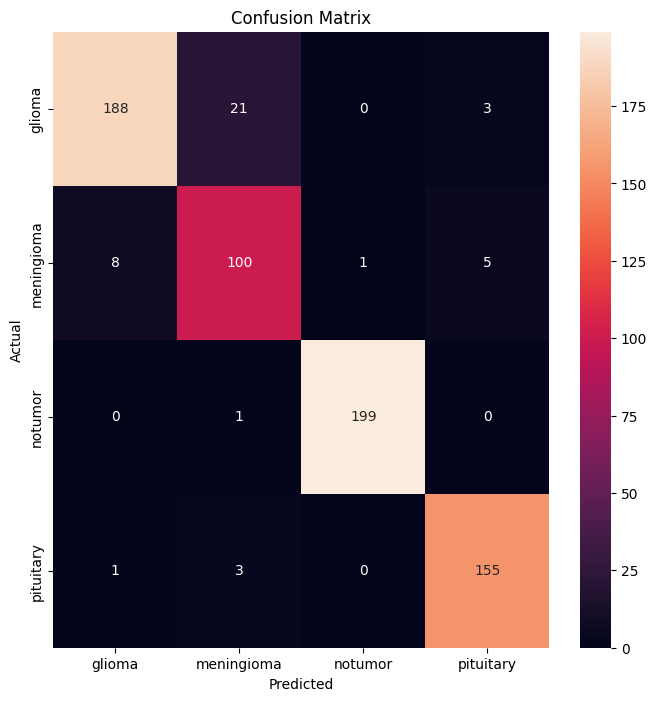

In [9]:
# Make predictions with the loaded model
pred = loaded_vit.predict(test_dataset)
loaded_vit.evaluate(test_dataset)
predicted = []
labels = []
for im, label in test_dataset:
    predicted.append(loaded_vit(im))
    labels.append(label.numpy())
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

# Plot the confusion matrix with actual labels
cm = confusion_matrix(lab, pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")
plt.show()

22/22 [==============================] - 2s 39ms/step
                 precision    recall  f1-score   support

         glioma       0.96      0.88      0.92       203
        notumor       0.96      0.94      0.95       132
pituitary tumor       0.77      0.91      0.83       111
     meningioma       1.00      1.00      1.00       239

       accuracy                           0.94       685
      macro avg       0.92      0.93      0.93       685
   weighted avg       0.94      0.94      0.94       685









<Figure size 800x600 with 0 Axes>

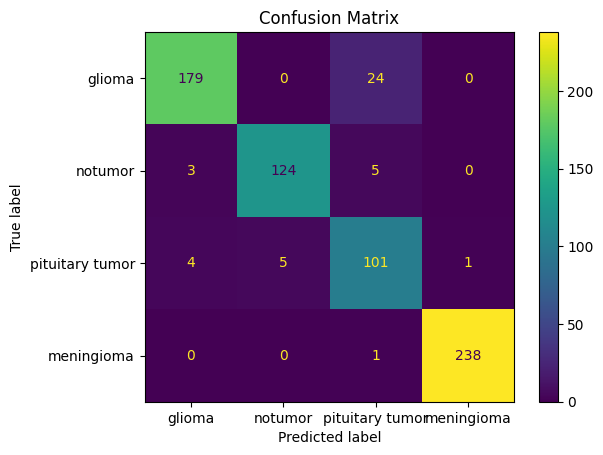

In [11]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Assuming 'Label' column contains the original labels
original_labels = df['Label'].unique()

# Define a function to evaluate the performance of a classification model using various metrics and visualizations.
def evaluate_metrics(y_pred, y_test, label_names):
    # Obtain and print unique labels from y_test and y_pred.
    labels = unique_labels(y_test, y_pred)
    # Generate and print a classification report showing precision, recall, F1-score, and support for each class.
    report = classification_report(y_test, y_pred, target_names=label_names)
    print(report)
    # Add spacing for clarity.
    print("\n" * 5)
    # Generate and display a confusion matrix.
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    plt.figure(figsize=(8, 6))
    cm_display.plot()
    plt.title('Confusion Matrix')
    plt.show()

# Predictions
model  = tf.keras.models.load_model('/content/drive/MyDrive/ProgettoDataMining/vit1')
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Map numeric classes to actual labels
y_pred_labels = [original_labels[i] for i in y_pred_classes]
y_val_labels = [original_labels[i] for i in y_val_classes]

# Evaluate the model
evaluate_metrics(y_pred_labels, y_val_labels, original_labels)
